Look for site-level differences in imaging parameters and measurements. Generate a table with this aggregated site-level information.

In [1]:
import os
import re
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from armed.misc import expand_data_path

In [2]:
strDataPath = expand_data_path('ADNI23_sMRI/image_info_quality_metrics.csv')
df = pd.read_csv(strDataPath, index_col=0)
df.columns

Index(['Diag', 'T1w_Path', 'Site', 'Model', 'Series_Description',
       'Slice_Thickness', 'TE', 'TR', 'Flip_Angle', 'Voxel_Size_X',
       'Voxel_Size_Y', 'Voxel_Size_Z', 'Hippocampus_Mean_Intensity',
       'Brain_Mean_Intensity', 'Brain_SD_Intensity',
       'Hippocampus_Edge_Contrast', 'Manufacturer', 'TI'],
      dtype='object')

In [3]:
# fill missing manufacturers
df.loc[df['Model'] == 'Skyra_fit', 'Manufacturer'] = 'Siemens'
df.loc[df['Model'] == 'Prisma_fit', 'Manufacturer'] = 'Siemens'

In [5]:
# Parse subject ID from image paths
def get_id(x):
    return re.search(r'sub-(\d*)_', x)[1]

df['Subject'] = df['T1w_Path'].apply(get_id)

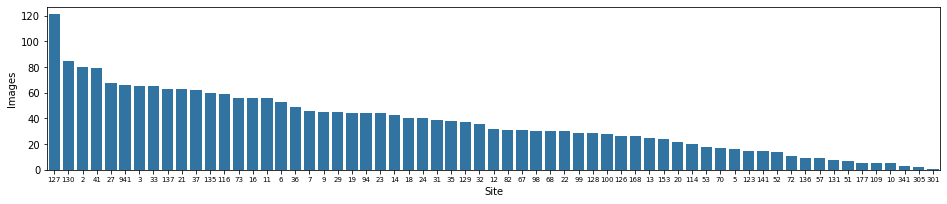

In [6]:
# Count number of images per site
dfSiteCounts = df['Site'].value_counts(ascending=False).to_frame('Images')
dfSiteCounts.index.name = 'Site'
sortorder = dfSiteCounts.index

fig, ax = plt.subplots(figsize=(16, 3))
sns.barplot(x=dfSiteCounts.index, y=dfSiteCounts['Images'], order=sortorder, ax=ax, color='C0')
ax.tick_params(axis='x', labelsize=7)

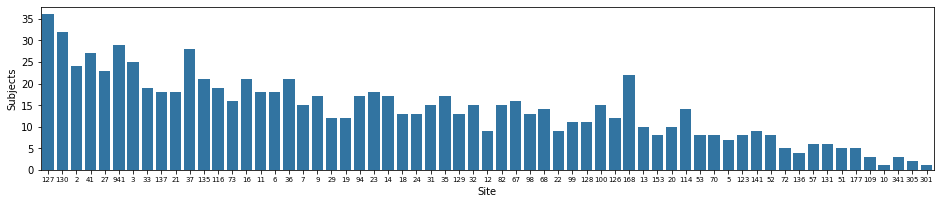

In [8]:
# Count number of subjects per site
dfSubjects = df.loc[~df['Subject'].duplicated()]

dfSiteSubjectCounts = dfSubjects['Site'].value_counts(ascending=False).to_frame('Subjects')
dfSiteSubjectCounts.index.name = 'Site'

fig, ax = plt.subplots(figsize=(16, 3))
sns.barplot(x=dfSiteSubjectCounts.index, y=dfSiteSubjectCounts['Subjects'], order=sortorder, ax=ax, color='C0')
ax.tick_params(axis='x', labelsize=7)

<AxesSubplot:xlabel='Manufacturer', ylabel='Site'>

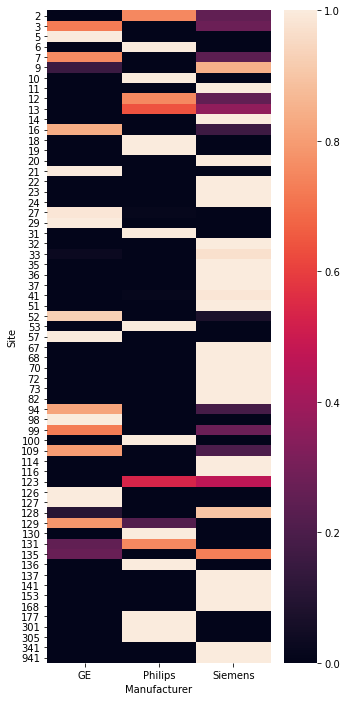

In [9]:
# Compute frequency of scanner manufacturers at each site
dfManuFreq = df.groupby('Site')['Manufacturer'].value_counts(normalize=True).to_frame('Frequency')
dfManuFreq.reset_index(inplace=True)
dfManuFreqWide = pd.pivot(dfManuFreq, index='Site', columns='Manufacturer')
dfManuFreqWide.columns = dfManuFreqWide.columns.droplevel(0)
dfManuFreqWide.fillna(0, inplace=True)

fig, ax = plt.subplots(figsize=(5, 12))
sns.heatmap(dfManuFreqWide, ax=ax)

In [10]:
# Find most common scanner model, sequence description, TR, TE, TI, Flip angle, etc. per site
lsCols = ['Model', 'Series_Description', 'TR', 'TE', 'TI', 'Flip_Angle', 'Voxel_Size_X', 'Voxel_Size_Y', 'Voxel_Size_Z']
dfModelSeq = df.groupby('Site')[lsCols].apply(pd.DataFrame.mode)
dfModelSeq.index = dfModelSeq.index.droplevel(level=1)
dfModelSeq

,Model,Series_Description,TR,TE,TI,Flip_Angle,Voxel_Size_X,Voxel_Size_Y,Voxel_Size_Z
Site,,,,,,,,,
2,Intera,MPRAGE SENSE2,0.006762,0.003112,0.9,9.0,1.199997,1.054688,1.054688
3,Signa HDxt,Accelerated SAG IR-SPGR,0.006964,0.002832,0.4,11.0,1.199997,1.054700,1.054700
5,DISCOVERY MR750,Accelerated Sag IR-FSPGR,0.007332,0.003036,0.4,11.0,1.199997,1.015600,1.015600
6,Ingenia,MPRAGE SENSE2,0.006744,0.003106,0.9,9.0,1.200012,1.054688,1.054688
7,Signa HDxt,Accelerated SAG IR-SPGR,0.006964,0.002832,0.4,11.0,1.199997,1.054700,1.054700
...,...,...,...,...,...,...,...,...,...
301,Ingenia,VWIP Coronal 3D Accelerated MPRAGE,0.006536,0.002944,NaN,9.0,0.500000,1.000000,0.500000
305,Achieva dStream,Sagittal 3D Accelerated MPRAGE,0.006512,0.002940,NaN,9.0,1.000000,1.000000,1.000000
305,NaN,NaN,0.006529,0.002941,NaN,NaN,NaN,NaN,NaN


In [11]:
# Compute median hippocampus intensity/contrast, whole brain intensity per site
lsCols = ['Hippocampus_Mean_Intensity', 'Hippocampus_Edge_Contrast', 'Brain_Mean_Intensity', 'Brain_SD_Intensity']
dfImageMetrics = df.groupby('Site')[lsCols].apply(pd.DataFrame.median)
dfImageMetrics

,Hippocampus_Mean_Intensity,Hippocampus_Edge_Contrast,Brain_Mean_Intensity,Brain_SD_Intensity
Site,,,,
2,1176.046971,67.500816,997.589619,359.735947
3,1106.455835,44.594744,1133.725240,414.571945
5,1158.123064,98.544132,1382.090775,564.550907
6,43211.193158,2622.015560,44236.603801,15138.634079
7,935.856207,52.804449,992.447567,401.733180
...,...,...,...,...
177,49861.174845,1233.472511,42810.020732,13708.856099
301,60116.823520,3466.709378,59763.031315,19354.493565
305,118214.169413,5026.601522,112824.298807,33423.488819


In [12]:
# Based on previous manual inspection, determine which images failed skullstripping
lsGoodSlices = glob.glob('/archive/bioinformatics/DLLab/KevinNguyen/data/ADNI23_sMRI/right_hippocampus_slices_2pctnorm/coronal_MNI-6_qc/good/*.png')
lsGoodSlices = [os.path.basename(s) for s in lsGoodSlices]
lsBadSlices = glob.glob('/archive/bioinformatics/DLLab/KevinNguyen/data/ADNI23_sMRI/right_hippocampus_slices_2pctnorm/coronal_MNI-6_qc/bad/*.png')
lsBadSlices = [os.path.basename(s) for s in lsBadSlices]

lsQC = []
for p in df['T1w_Path'].values:
    n = os.path.basename(p)
    n = n.replace('_run-01', '')
    if (n.replace('T1w.nii.gz', 'CN.png') in lsGoodSlices) | (n.replace('T1w.nii.gz', 'Dementia.png') in lsGoodSlices):
        lsQC += ['good']
    elif (n.replace('T1w.nii.gz', 'CN.png') in lsBadSlices) | (n.replace('T1w.nii.gz', 'Dementia.png') in lsBadSlices):
        lsQC += ['bad']
    else:
        print(n)
df['Skullstripping_Quality'] = lsQC
df['Skullstripping_Quality'].value_counts()

good    2217
bad      103
Name: Skullstripping_Quality, dtype: int64

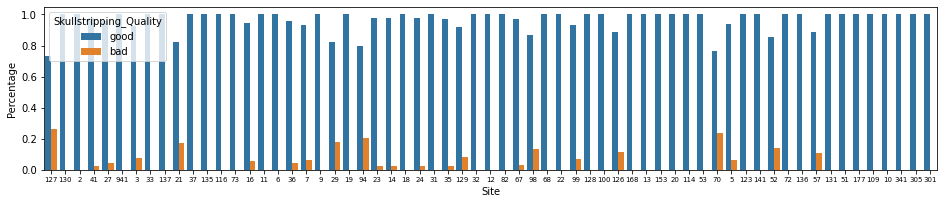

In [13]:
dfQualityPct = (df.groupby('Site')['Skullstripping_Quality']).value_counts(normalize=True)
dfQualityPct = dfQualityPct.to_frame('Percentage')
dfQualityPct.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(16, 3))
sns.barplot(data=dfQualityPct, x='Site', y='Percentage', hue='Skullstripping_Quality', order=sortorder, ax=ax)
ax.tick_params(axis='x', labelsize=7)

In [14]:
dfQualityPctWide = pd.pivot(dfQualityPct, index='Site', columns='Skullstripping_Quality')
dfQualityPctWide.fillna(0, inplace=True)
lsNewCols = ['Skullstripping_Quality_' + t[1].capitalize() for t in dfQualityPctWide.columns]
dfQualityPctWide.columns = lsNewCols
dfQualityPctWide

,Skullstripping_Quality_Bad,Skullstripping_Quality_Good
Site,,
2,0.000000,1.000000
3,0.076923,0.923077
5,0.062500,0.937500
6,0.000000,1.000000
7,0.065217,0.934783
...,...,...
177,0.000000,1.000000
301,0.000000,1.000000
305,0.000000,1.000000


In [15]:
dfImageInfo = pd.read_csv('image_list_ad_cn.csv', index_col=0)
dfDiagPct = dfImageInfo.groupby('Site')['DX_Scan'].value_counts(normalize=True)
dfADPct = dfDiagPct.loc[dfDiagPct.index.get_level_values(1) == 'Dementia']
dfADPct.index = dfADPct.index.droplevel(level=1)
dfADPct = dfADPct.to_frame('Percent_AD')

In [16]:
dfTable = pd.concat([dfSiteCounts, dfSiteSubjectCounts, dfManuFreqWide, dfModelSeq, dfImageMetrics, 
                     dfQualityPctWide, dfADPct], axis=1)
dfTable['Percent_AD'].fillna(0, inplace=True)
dfTable

,Images,Subjects,GE,Philips,Siemens,Model,Series_Description,TR,TE,TI,...,Voxel_Size_X,Voxel_Size_Y,Voxel_Size_Z,Hippocampus_Mean_Intensity,Hippocampus_Edge_Contrast,Brain_Mean_Intensity,Brain_SD_Intensity,Skullstripping_Quality_Bad,Skullstripping_Quality_Good,Percent_AD
Site,,,,,,,,,,,,,,,,,,,,,
2,80,24,0.000000,0.75,0.250000,Intera,MPRAGE SENSE2,0.006762,0.003112,0.9,...,1.199997,1.054688,1.054688,1176.046971,67.500816,997.589619,359.735947,0.000000,1.000000,0.112500
3,65,25,0.723077,0.00,0.276923,Signa HDxt,Accelerated SAG IR-SPGR,0.006964,0.002832,0.4,...,1.199997,1.054700,1.054700,1106.455835,44.594744,1133.725240,414.571945,0.076923,0.923077,0.261538
5,16,7,1.000000,0.00,0.000000,DISCOVERY MR750,Accelerated Sag IR-FSPGR,0.007332,0.003036,0.4,...,1.199997,1.015600,1.015600,1158.123064,98.544132,1382.090775,564.550907,0.062500,0.937500,0.812500
6,53,18,0.000000,1.00,0.000000,Ingenia,MPRAGE SENSE2,0.006744,0.003106,0.9,...,1.200012,1.054688,1.054688,43211.193158,2622.015560,44236.603801,15138.634079,0.000000,1.000000,0.396226
7,46,15,0.760870,0.00,0.239130,Signa HDxt,Accelerated SAG IR-SPGR,0.006964,0.002832,0.4,...,1.199997,1.054700,1.054700,935.856207,52.804449,992.447567,401.733180,0.065217,0.934783,0.239130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,1,1,0.000000,1.00,0.000000,Ingenia,VWIP Coronal 3D Accelerated MPRAGE,0.006536,0.002944,NaN,...,0.500000,1.000000,0.500000,60116.823520,3466.709378,59763.031315,19354.493565,0.000000,1.000000,0.000000
305,2,2,0.000000,1.00,0.000000,Achieva dStream,Sagittal 3D Accelerated MPRAGE,0.006512,0.002940,NaN,...,1.000000,1.000000,1.000000,118214.169413,5026.601522,112824.298807,33423.488819,0.000000,1.000000,0.500000
305,2,2,0.000000,1.00,0.000000,NaN,NaN,0.006529,0.002941,NaN,...,NaN,NaN,NaN,118214.169413,5026.601522,112824.298807,33423.488819,0.000000,1.000000,0.500000


In [17]:
dfTable.to_excel(expand_data_path('ADNI23_sMRI/image_info_quality_metrics_aggregated_v2.xlsx'))